# **Machine Learning 1**

## **Mini-Lab: SVM & LR Classification**

Randy Kim, Kati Schuerger, Will Sherman

The PlayerUnknown’s Battleground (also known as PUBG) Finish Placement Prediction Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." We are continuing our analysis from **Lab One: "Visualization and Data Preprocessing."** However, we will focus on response transformation to evaluate classification accuracy on quartiles of *winPlacePerc*, which we will evaluate in combination with 10-fold cross-validation

*Note*: We are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric will be covered.

#### Library & Data Import Methods ####

In [1]:
# load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statistics
import time

# import libraries to clean up CopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# load in the data
pubg_raw = pd.read_csv("train_V2.csv")

In [3]:
# this logic iterates through the DF to reduce memory usage
# code adapted from https://www.kaggle.com/yansun1996/gbr-ipynb
# additional reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
pubg_raw = reduce_mem_usage(pubg_raw)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


### Data Evaluation & Transformation Prior to Modeling ###

In [5]:
pubg_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


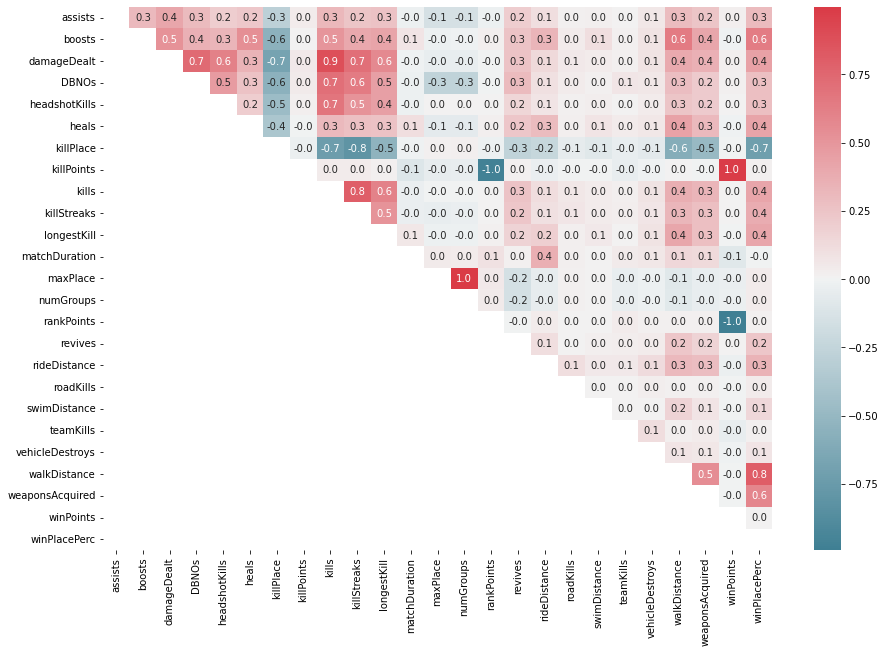

In [6]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_raw.corr()
heatPlot = sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
                       mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))
plt.show()

We utilized the analysis from **Lab 1** to inform our approach in dropping NA values as opposed to imputing them. For reference, there was only a single NA value.

In [7]:
# CREATE PUBG_DF TO INCLUDE OUR UPDATES
# drop records with missing values (there is only one)
pubg_df_stg = pubg_raw.dropna()
pubg_df_stg.isnull().values.any()

False

However, we identified that in the numeric column for *rankPoints* there were a subset of values that were "unranked", yet these were given a value of -1. We believe this was negatively impacting our modeling (specifically modeling time). For the purposes of this study, we will proceed without the unranked matches.

In [8]:
# we have some records with -1 values = take the place of NULL

x = pubg_df_stg['rankPoints']
y = pubg_df_stg['winPoints']
z = pubg_df_stg['killPoints']

print(x[x==-1].count())
print(y[y==-1].count())
print(z[z==-1].count())
print(pubg_df_stg.shape[0]-x[x==-1].count())

1701810
0
0
2745155


In [9]:
# SUBSET OUR DATA TO ONLY RETAIN RANKED MATCHES
# we have some records with -1 values = take the place of NULL
## dropping these to subset our dataset & because they represent non-ranked matches

pubg_df = pubg_df_stg[(pubg_df_stg.iloc[:,:] != -1).all(axis=1)]
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987


<AxesSubplot:>

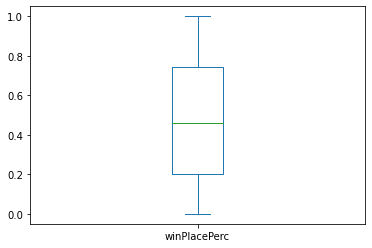

In [10]:
# boxplot of our target variable 
# data looks pretty well-distributed, possibly a little right-skewed
# makes sense = would expect to have fewer records as the quartile increases 
pubg_df.loc[:, 'winPlacePerc'].plot(kind='box')

Our initial approach was to subdivide the players into quartiles and use a classification algorithm to sort players into these quartiles. However, to answer our question of interest, we really only need to predict players in the top (winning) quartile. We changed our methodology to reflect this classification task, and built the models as binary classifiers.

*Given we may pursue incorporating a multiclass prediction model down the line, we have not removed the code to create the other 2 variables that we are not using for this exercise (quartlie and quart_int). Additionally, these were part of our learning process in changing course to build binary classification models.*

In [11]:
# GATHER THRESHOLDS FOR US TO SET OUR QARTILES 
# pull out the winPlacePerc column
winPlace = pubg_df.loc[:,'winPlacePerc']

# get quartile thresholds for equal allocation |
print('Quartile 1 threshold: {:.2f}'.format(winPlace.quantile(0.25)))
print('Quartile 2 threshold: {:.2f}'.format(winPlace.quantile(0.5)))
print('Quartile 3 threshold: {:.2f}'.format(winPlace.quantile(0.75)))

Quartile 1 threshold: 0.20
Quartile 2 threshold: 0.46
Quartile 3 threshold: 0.74


This tells us that the thresholds between quartiles in our data are a little different from the "basic" quartiles split (0.25, 0.5, 0.75).

We will adjust our thresholds in the 'quartile' column, to reflect the revised thresholds (derived from the actual data).

In [12]:
# create new variable fields to use for our predictions (quartile, quart_int, quart_binary)
# we will use quart_binary for our classification task in this mini-lab

pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.46, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.74, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, 'q4',
                                                  'other'))))
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1', 
                       np.where(pubg_df.winPlacePerc < 0.46, '2',
                                np.where(pubg_df.winPlacePerc < 0.74, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '4',
                                                  'other'))))
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.74, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '1',
                                                  'other'))
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,11.039062,0,0,1434.0000,5,0,0.640137,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0.000000,0,0,161.7500,2,0,0.775391,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0.000000,0,0,202.7500,3,0,0.166748,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0.000000,0,0,49.7500,2,0,0.187500,q1,1,0
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0.000000,0,0,34.6875,1,0,0.036987,q1,1,0


In [13]:
# check the spread of our quartiles
# make sure they are balanced

quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 24.86%
Percentage of players in Quartile 2: 25.19%
Percentage of players in Quartile 3: 24.55%
Percentage of players in Quartile 4: 25.41%
Miscategorized quartile values:   0


In [14]:
# remove some unuseful object-datatype variables 
del pubg_df['Id']
del pubg_df['groupId']
del pubg_df['matchId']
del pubg_df['matchType']

The *Id*, *groupId*, and *matchId* features are important for distinguishing distinct players, groups, and matches as part of the original kaggle competition. However, these are not good predictors for our binary classification problem—each triplet will be unique. Therefore, these three are dropped as non-essential.

The *matchType* variable was previously identified as having low correlation and predictive power with respect to the original (continuous) response variable, *winPlacePerc*. As such, we opted to remove it from our predictors.

*Note*: Analysis on *matchType* was provided in **Lab 1** as part of the **EXPLORE ATTRIBUTES & CLASS** section.

In [15]:
# FEATURE COLUMN NAMES 
# make a list of the columns in our df (to be used for models below)

cols_df = pubg_df.columns.values.tolist()
cols_df.remove('winPlacePerc') # remove target variable 1 (continuous)
cols_df.remove('quartile') # remove target variable 2 (categorical)
cols_df.remove('quart_int') # remove target variable 2 (numeric representation)
cols_df.remove('quart_binary')
print(cols_df)

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']


Below we re-evaluate the features we have transformed and selected. Above, the **Feature Column Names** code block lists the predictors we will utilize to create the logistic regression model and support vector machine model for the classification task.

<AxesSubplot:>

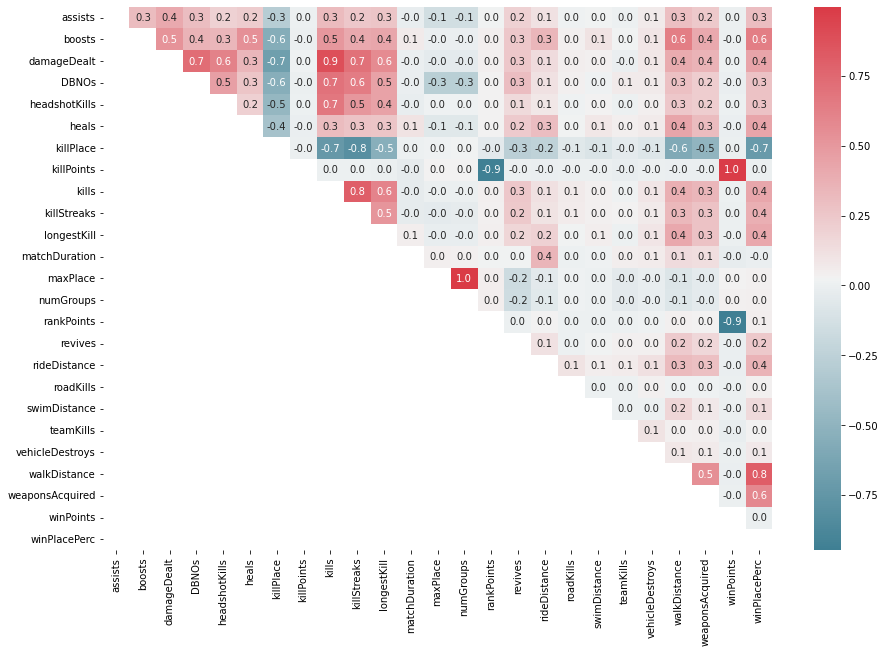

In [16]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_df.corr()
sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
            mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))

Due to the high correlation between *winPoints*, *rankPoints*, and *killPoints*, we will need to reduce the parameters to avoid multicollinearity within the predictors.

There is also a strong correlation between *maxPlace* and *numGroups*; therefore, we will keep *numGroups* which is a direct descriptor of the number of teams or individuals playing in a given match.


In [17]:
# remove additional variables that are causing extra noise in our model
# (specifically, these variables are highly correlated with other variables 
# which impacts our model's convergence perfomance)

cols_df.remove('winPoints') # highly correlated with rankPoints and killPoints
cols_df.remove('killPoints') # highly correlated with rabnkPoints and winPoints
cols_df.remove('maxPlace') # perfectly correlated with numGroups
print(cols_df)

# We maintain the rankPoints variable since we subset on this earlier to only work with 'ranked' matches

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired']


This next block presents the structure of the final dataset—verifying it meets minimum rows & columns in addition to identifying relevant features for analysis

In [18]:
pubg_df.info() 

# note: we will be calling the cols_df as predictors & quart_binary as target variable
# we will not be utilizing these response vectors for the Mini-Lab: winPlacePerc, quartile, quart_int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745155 entries, 1 to 4446965
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   killPoints       int16  
 8   kills            int8   
 9   killStreaks      int8   
 10  longestKill      float16
 11  matchDuration    int16  
 12  maxPlace         int8   
 13  numGroups        int8   
 14  rankPoints       int16  
 15  revives          int8   
 16  rideDistance     float16
 17  roadKills        int8   
 18  swimDistance     float16
 19  teamKills        int8   
 20  vehicleDestroys  int8   
 21  walkDistance     float16
 22  weaponsAcquired  int16  
 23  winPoints        int16  
 24  winPlacePerc     float16
 25  quartile         object 
 26  quart_int        object 
 27  quart_binary

## **CREATE MODELS** ##

Our initial approach (below) was to use unscaled data and fit a model we have more familiarity with: logistic regression.

### *Regression Model to Predict Binary Classification Variable*

In [19]:
# SIMPLE LOGIT MODEL 
## Create Logistic Regression Model & Score Model using train, test, split

start_time = time.time()

# make our TRAIN/TEST SPLIT
feature_cols = cols_df
X = pubg_df.loc[:, feature_cols]
y = pubg_df.loc[:,'quart_binary']
# y = pubg_df.loc[:, 'quartile']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2, random_state=17)

logit_simple = LogisticRegression()
logit_simple.fit(X_train, y_train)

print('Logistic Regression Simple Score: {:.2f}%'.format(logit_simple.score(X_test, y_test)*100))
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Simple Score: 89.64%
--- 11.42048692703247 seconds ---


For the simple logistic model (above), we encountered a ConvergenceWarning. This may be due to some remaining multicollinearity (e.g. *damageDealt* with *kills*). However, we will continue with the given feature-space—with caution.

In order to potentially deal with this, we will increase the number of iterations.

In [20]:
start_time = time.time()

# repeating this step for completeness of code (do not need to run it bc we already ran above)
# feature_cols = cols_df
# X = pubg_df.loc[:, feature_cols]
# y = pubg_df.loc[:, 'quart_binary']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.2, random_state=17)

logit_simple = LogisticRegression(max_iter=4000) # increase maximum iterations
logit_simple.fit(X_train, y_train)

print('Logistic Regression Simple Score: {:.2f}%'.format(logit_simple.score(X_test, y_test)*100))
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Simple Score: 90.28%
--- 227.3818233013153 seconds ---


For both classification tasks, we are seeing ConvergenceWarning(s) due to reaching the maximum number of iterations. However, we will proceed without allowing lbfgs to converge, since increasing the max_iter will invariably increase our run-time(s).

#### *Build Pipelines* ##

Here we created a pipeline that scales and fit 3 different classifications, Logistic Regression, Decision Tree, and Random Forest, to compare their accuracies. Because of how large the dataset is, overfitting issues, high variance, and noise—Random Forest performed better than other classifications. Although the training time was slower than others, Random Forest improves accuracy by using its main advantages.

-------------------------------------------------------------------------------

**Logistic Regression Accuracy**: 0.904

**Decision Tree Accuracy**: 0.892

**RandomForest Accuracy**: 0.925


In [21]:
pipeline_lr = Pipeline([('scalar1', StandardScaler()),
                        ('lr_classifier', LogisticRegression(random_state=17))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', DecisionTreeClassifier(random_state=17))])

pipeline_randomforest = Pipeline([('scalar3', StandardScaler()),
                                  ('rf_classifier', RandomForestClassifier(random_state=17))])

pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]
pipelines

[Pipeline(steps=[('scalar1', StandardScaler()),
                 ('lr_classifier', LogisticRegression(random_state=17))]),
 Pipeline(steps=[('scalar2', StandardScaler()),
                 ('dt_classifier', DecisionTreeClassifier(random_state=17))]),
 Pipeline(steps=[('scalar3', StandardScaler()),
                 ('rf_classifier', RandomForestClassifier(random_state=17))])]

In [22]:
best_accuracy = 0.0
best_classifier = 0
best_pipline = ""

pipe_dic = {0: "Logistic Regression", 1: "Decision Tree", 2: "RandomForest"}

In [23]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [24]:
for i,model in enumerate(pipelines):
    start_time = time.time()
    accuracy = model.score(X_test, y_test)
    print("{} Test Accuracy: {}".format(pipe_dic[i],accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pipeline = model
        best_classifier = i
    print("--- %s seconds ---" % (time.time() - start_time))
    
print("\nClassifier with best accuracy: {} with {}.".format(pipe_dic[best_classifier], best_accuracy))

Logistic Regression Test Accuracy: 0.9037923177379784
--- 4.949486017227173 seconds ---
Decision Tree Test Accuracy: 0.8924263839382476
--- 4.994973182678223 seconds ---
RandomForest Test Accuracy: 0.924844407692826
--- 52.36741042137146 seconds ---

Classifier with best accuracy: RandomForest with 0.924844407692826.


### **Hyperparameter Tuning for Logistic Regression**

To help decrease the run-time for hyperparameter tuning, a subsample of 10% of the data was made. This will still represent about 270,000 records.

In [25]:
#Create subset of data to decrease hyperparameter tuning run-time
pubg_sample = pubg_df.sample(frac=0.1)

X = pubg_sample.loc[:, feature_cols]
y = pubg_sample.loc[:,'quart_binary']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.2, random_state=17)

In [26]:
pipe = Pipeline([('scalar', StandardScaler()),
                 ('classifier', LogisticRegression(random_state = 17))])

In [27]:
grid_param = [
    {"classifier": [LogisticRegression()],
    "classifier__penalty": ["l2"],
    "classifier__C": np.logspace(-1, 4, 8),
    "classifier__solver":["newton-cg", "saga", "sag", "liblinear"],
    "classifier__max_iter": [10, 100, 1000]
    }
]

In [28]:
start_time = time.time()

gridsearch = GridSearchCV(pipe, grid_param, cv = 10, verbose = 0, n_jobs = -1)
best_model = gridsearch.fit(X_train, y_train)
acc = best_model.score(X_test, y_test)

print(best_model.best_estimator_)
print("The mean accuracy of the model is:", acc)
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10, solver='saga'))])
The mean accuracy of the model is: 0.9042133207050584
--- 156.19747877120972 seconds ---


In [29]:
df_lr = pd.DataFrame(best_model.cv_results_)
df_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__max_iter,param_classifier__penalty,param_classifier__solver,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.738724,0.018770,0.024235,0.001611,"LogisticRegression(C=0.1, max_iter=10, solver=...",0.1,10,l2,newton-cg,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904554,0.901093,0.907104,0.897086,0.900182,0.901275,0.898179,0.902282,0.003113,16
1,0.699728,0.125914,0.023936,0.009335,"LogisticRegression(C=0.1, max_iter=10, solver=...",0.1,10,l2,saga,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.907468,0.901457,0.908015,0.896721,0.899454,0.901639,0.900364,0.903338,0.003777,1
2,0.633305,0.066382,0.020944,0.002185,"LogisticRegression(C=0.1, max_iter=10, solver=...",0.1,10,l2,sag,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904554,0.900911,0.907286,0.896903,0.899818,0.901457,0.897814,0.902318,0.003328,11
3,1.966540,0.107456,0.024934,0.002230,"LogisticRegression(C=0.1, max_iter=10, solver=...",0.1,10,l2,liblinear,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904372,0.901275,0.907468,0.897268,0.900182,0.901093,0.897996,0.902282,0.003132,13
4,2.540904,0.714851,0.022140,0.005828,"LogisticRegression(C=0.1, max_iter=10, solver=...",0.1,100,l2,newton-cg,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904189,0.901275,0.907286,0.896903,0.900182,0.900729,0.898179,0.902191,0.003142,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2.536216,0.608501,0.029521,0.008547,"LogisticRegression(C=0.1, max_iter=10, solver=...",10000.0,100,l2,liblinear,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904189,0.900546,0.907286,0.896721,0.899818,0.899818,0.898179,0.901863,0.003211,72
92,2.663974,0.821219,0.027726,0.012148,"LogisticRegression(C=0.1, max_iter=10, solver=...",10000.0,1000,l2,newton-cg,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904189,0.900546,0.907286,0.896721,0.899818,0.899818,0.898179,0.901863,0.003211,72
93,2.340142,0.340252,0.024534,0.005610,"LogisticRegression(C=0.1, max_iter=10, solver=...",10000.0,1000,l2,saga,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904007,0.901275,0.907650,0.897268,0.900000,0.900182,0.898361,0.902136,0.003131,28
94,1.282968,0.236001,0.029722,0.016349,"LogisticRegression(C=0.1, max_iter=10, solver=...",10000.0,1000,l2,sag,"{'classifier': LogisticRegression(C=0.1, max_i...",...,0.904189,0.901093,0.907468,0.896721,0.900000,0.900000,0.898361,0.902009,0.003186,50


In [30]:
lr = df_lr[["param_classifier","param_classifier__solver", "param_classifier__C", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head(10)
lr.style.set_properties(subset=['param_classifier'], **{'width': '300px'})

,param_classifier,param_classifier__solver,param_classifier__C,mean_test_score
1,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,0.100000,0.903338
49,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,71.968567,0.903247
73,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,1930.697729,0.903247
13,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,0.517947,0.903229
25,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,2.682696,0.903211
85,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,10000.000000,0.903175
61,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,372.759372,0.903175
37,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",saga,13.894955,0.903120
38,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",sag,13.894955,0.902337
74,"LogisticRegression(C=0.1, max_iter=10, solver='saga')",sag,1930.697729,0.902319


In [31]:
lr_opt = lr['param_classifier'].iloc[0]
print(lr_opt)

LogisticRegression(C=0.1, max_iter=10, solver='saga')


In [32]:
from sklearn.metrics import confusion_matrix

# verifying confusion matrix for LogisticRegression(max_iter=6, solver='newton-cg', C=1):
y_pred = best_model.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[154262   9633]
 [ 11403  44315]]


Finally, we've provided the confusion matrix (above) to identify that we aren't *obviously* overfitting directionally for our binomial classification. That is, our model isn't placing all individuals in the "bottom 75th percentile" in order to achieve an accuracy of 90%.

### **Logistic Regression using Stochastic Gradient Descent**

Whereas linear regression minimizes squared error, logistic regression minimizes log-loss (also known as cross-entropy). [This article](http://rasbt.github.io/mlxtend/user_guide/classifier/LogisticRegression/) can be referenced for a detailed explanation.

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import statistics
# use some compact notation for creating a logistic regression classifier with stochastic descent

regularize_const = 0.1
iterations = 5
acc = []

# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits (80/20 split)
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, random_state=17,
                         test_size=0.2)

Xn = pubg_df.loc[:, feature_cols]
yn = pubg_df.loc[:,'quart_binary']

log_sgd = SGDClassifier(alpha=regularize_const,
                        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
                        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()

for train_idx, test_idx in cv_object.split(Xn,yn):
    log_sgd.fit(scl.fit_transform(Xn.iloc[train_idx]),yn.iloc[train_idx])
    yhat = log_sgd.predict(scl.transform(Xn.iloc[test_idx]))
    
    acc.append(mt.accuracy_score(yn.iloc[test_idx], yhat))

print('Logistic Regression using SGD:', statistics.mean(acc))

## code adapted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


Logistic Regression using SGD: 0.8808724826102715


Utilizing *SGDClassifier()* allowed us to train a model in a much shorter timeframe than the previous regression models.

We trained the *SGDClassifier()* with the hinge loss, which is equivalent to a linear SVM (reference: https://scikit-learn.org/stable/modules/sgd.html#sgd).

### **Hyperparameter Tuning for Logistic Regression using Stochastic Gradient Descent**

In [34]:
# SVM HYPERPARAMETER TUNING
pipe_sgd = Pipeline([('scalar', StandardScaler()),
                    ('classifier', SGDClassifier(random_state = 17))])
grid_param = [
    {"classifier__loss": ["hinge", "log", "perceptron"],
    "classifier__alpha": np.logspace(-3,3,7),
    "classifier__penalty": ['l2'],
    "classifier__learning_rate": ["optimal"],
    "classifier__n_iter_no_change": [10, 100, 1000]
    }
]

In [35]:
start_time = time.time()

gridsearch = GridSearchCV(pipe_sgd, grid_param, cv = 10, verbose = 0, n_jobs = -1)
best_model = gridsearch.fit(X_train, y_train)
acc = best_model.score(X_test, y_test)

print(best_model.best_estimator_)
print("The mean accuracy of the model is:", acc)
print("--- %s seconds ---" % (time.time() - start_time))

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=0.001, n_iter_no_change=100,
                               random_state=17))])
The mean accuracy of the model is: 0.9045457236138116
--- 534.0082025527954 seconds ---


In [36]:
df_sg = pd.DataFrame(best_model.cv_results_)
df_sg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__learning_rate,param_classifier__loss,param_classifier__n_iter_no_change,param_classifier__penalty,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.639181,0.072725,0.024235,0.003863,0.001,optimal,hinge,10,l2,"{'classifier__alpha': 0.001, 'classifier__lear...",...,0.905282,0.900364,0.904918,0.895264,0.898361,0.895993,0.901093,0.901790,0.004043,9
1,2.948996,0.243054,0.023439,0.003603,0.001,optimal,hinge,100,l2,"{'classifier__alpha': 0.001, 'classifier__lear...",...,0.905282,0.902186,0.908197,0.898543,0.900729,0.901821,0.899271,0.903484,0.003315,1
2,24.999033,1.175294,0.023378,0.001998,0.001,optimal,hinge,1000,l2,"{'classifier__alpha': 0.001, 'classifier__lear...",...,0.905647,0.901639,0.906740,0.898179,0.901275,0.901457,0.898725,0.903193,0.003343,2
3,0.648961,0.061356,0.022822,0.003236,0.001,optimal,log,10,l2,"{'classifier__alpha': 0.001, 'classifier__lear...",...,0.905829,0.901275,0.906193,0.896175,0.900546,0.901457,0.899454,0.902428,0.003179,5
4,3.207146,0.042121,0.019997,0.001148,0.001,optimal,log,100,l2,"{'classifier__alpha': 0.001, 'classifier__lear...",...,0.905282,0.901457,0.907286,0.895993,0.898907,0.902550,0.897632,0.902628,0.003815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,3.520071,0.370221,0.023989,0.005025,1000.0,optimal,log,100,l2,"{'classifier__alpha': 1000.0, 'classifier__lea...",...,0.253005,0.253005,0.253005,0.253005,0.746995,0.746995,0.746995,0.401225,0.226359,46
59,29.046427,2.055066,0.019727,0.001350,1000.0,optimal,log,1000,l2,"{'classifier__alpha': 1000.0, 'classifier__lea...",...,0.253005,0.253005,0.253005,0.253005,0.746995,0.746995,0.746995,0.401225,0.226359,46
60,0.407656,0.015205,0.018193,0.002135,1000.0,optimal,perceptron,10,l2,"{'classifier__alpha': 1000.0, 'classifier__lea...",...,0.253005,0.253005,0.253005,0.253005,0.746995,0.746995,0.746995,0.401225,0.226359,46
61,2.404710,0.192584,0.019358,0.002715,1000.0,optimal,perceptron,100,l2,"{'classifier__alpha': 1000.0, 'classifier__lea...",...,0.253005,0.253005,0.253005,0.253005,0.746995,0.746995,0.746995,0.401225,0.226359,46


In [37]:
sg = df_sg[["params","param_classifier__loss", "param_classifier__alpha","mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head(10)
sg.style.set_properties(subset=['params'], **{'width': '300px'})

,params,param_classifier__loss,param_classifier__alpha,mean_test_score
1,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 100, 'classifier__penalty': 'l2'}",hinge,0.001000,0.903484
2,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 1000, 'classifier__penalty': 'l2'}",hinge,0.001000,0.903193
5,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__n_iter_no_change': 1000, 'classifier__penalty': 'l2'}",log,0.001000,0.903011
4,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__n_iter_no_change': 100, 'classifier__penalty': 'l2'}",log,0.001000,0.902628
3,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__n_iter_no_change': 10, 'classifier__penalty': 'l2'}",log,0.001000,0.902428
11,"{'classifier__alpha': 0.01, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 1000, 'classifier__penalty': 'l2'}",hinge,0.010000,0.902027
9,"{'classifier__alpha': 0.01, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 10, 'classifier__penalty': 'l2'}",hinge,0.010000,0.901991
10,"{'classifier__alpha': 0.01, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 100, 'classifier__penalty': 'l2'}",hinge,0.010000,0.901881
0,"{'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge', 'classifier__n_iter_no_change': 10, 'classifier__penalty': 'l2'}",hinge,0.001000,0.901790
14,"{'classifier__alpha': 0.01, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__n_iter_no_change': 1000, 'classifier__penalty': 'l2'}",log,0.010000,0.900315


## **MODEL ADVANTAGES**

The logistic model using stochastic gradient descent (SGD) runs much faster than the previous models. The 10-fold cross-validation of the simple logistic regression model took about 5 minutes when running high iterations (and was still unable to converge). The SGD approach takes around 3 minutes to run a 10-fold cross-validation.

The trade off is that we see a slightly lower average accuracy score (we pay for our improved computing speed with about 1 to 2% accuracy = it drops from around 90% to around 88%).

But, 88% accuracy is still pretty solid. Additionally, the variance of the scores doesn't seem to suffer drastically. As for next steps, we could explore methods to reduce the  dimensionality of our data, to see if we can bring our accuracy score up without a substantal increase in processing time.

The *SGDClassifier* did not show marked improvement over the DecisionTree and RandomForest approaches, both in terms of accuracy scores and in terms of time-to-completion. **This is distinct** compared to our original approach from the first submission of the mini-lab. It appears that removing the *unranked* matches from the original dataset positively affected the non-parametric models. Also of note is the increase in accuracy that hyperparameter tuning gave but that the run-time increased with increased iterations.

Lastly, between the logistic regression using stochastic gradient descent and the support vector machine, it appears that the SVM model has a slight advantage both in terms of run-time and accuracy.

## **INTERPRETING FEATURE IMPORTANCE**  *edited*

In [38]:
# INTERPRETTING WEIGHTS

pipe = Pipeline([('scalar', StandardScaler()),
                 ('classifier', lr_opt)])
# iterate over the coefficients
lr_best = pipe.fit(X_train, y_train)
weights = abs(lr_best.named_steps['classifier'].coef_[0])

variable_names = cols_df
for coef, name in zip(weights, variable_names):
    print(name, 'has weight of', coef)

assists has weight of 0.13189417
boosts has weight of 0.4116481
damageDealt has weight of 0.11767393
DBNOs has weight of 0.11140397
headshotKills has weight of 0.0091954535
heals has weight of 0.031161811
killPlace has weight of 2.0898056
kills has weight of 0.23139851
killStreaks has weight of 0.78190374
longestKill has weight of 0.011036668
matchDuration has weight of 0.64714456
numGroups has weight of 0.29484427
rankPoints has weight of 0.04612249
revives has weight of 0.03408298
rideDistance has weight of 0.37010667
roadKills has weight of 0.005191717
swimDistance has weight of 0.11732215
teamKills has weight of 0.03988501
vehicleDestroys has weight of 0.0051422305
walkDistance has weight of 1.6390047
weaponsAcquired has weight of 0.14307411


C:\Users\sherm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


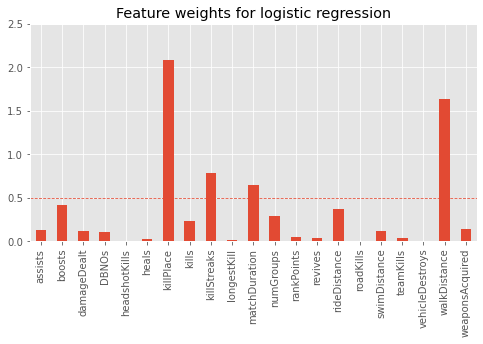

In [39]:
%matplotlib inline
plt.style.use('ggplot')

weights_graph = pd.Series(weights.flatten(), index=variable_names)
plt.figure(figsize=(8, 4))
plt.ylim(ymin=0,ymax=2.5)
wg = weights_graph.plot(kind='bar')
wg.axhline(y=0.5, linestyle='--', linewidth=0.8)

plt.title('Feature weights for logistic regression')
plt.show()

We can see from the graph above that *killPlace* is the feature with the most importance in our model, followed by *walkDistance*, *killStreaks*, and then *matchDuration*. Here are a few comments about each of these.

1. killPlace: This variable represents a ranking in a given match, based on the number of enemy players killed. More enemy players killed means a better placement—which means a lower. It makes sense that this would be influential for our target variable, destroying a greater number of the other players means that there are fewer players to place higher than you. Additional research into analysis performed by others suggests that very few players adopt a 'passive' strategy (one in which they do not go on the offensive, attacking other players), and that even fewer manage to place highly in a given match when they have a minimal enemy kill count.

2. walkDistance: This variable represents the total distance walked by a player during the match. It makes sense that the walk distance would be an imporant factor for influencing the target variable (*quart_binary*); a player that places higher would be alive longer, and travel a greater distance, as compared to players that place lower (aka die early).

3. killStreaks: This represents the number of enemy players killed in a short amount of time. This represents a player that may get a higher killPlace (so there may be some multicollinearity here). Additionally, gettin gmore killStreaks will likely place that individual higher in rankings.

4. matchDuration: This feature is the only one that doesn't necessarily make sense. Since this is the length of time a match goes on—and not how long a player survives—we would expect this feature to have lower importance.

All other vectors have weights less than 0.4.

### *Feature Importance for Random Forest Model* #new section

In [40]:
pipeline_randomforest.steps[1]

('rf_classifier', RandomForestClassifier(random_state=17))

In [41]:
pipeline_randomforest.steps[1][1].feature_importances_

array([0.0085096 , 0.10517832, 0.0462004 , 0.01085611, 0.00663614,
       0.05041564, 0.16985099, 0.02223203, 0.01486909, 0.05423425,
       0.04664964, 0.03690244, 0.03563346, 0.00559869, 0.03304155,
       0.00045464, 0.01053425, 0.00192719, 0.00091185, 0.29357673,
       0.04578698])

Feature: assists          Score: 0.00851
Feature: boosts           Score: 0.10518
Feature: damageDealt      Score: 0.04620
Feature: DBNOs            Score: 0.01086
Feature: headshotKills    Score: 0.00664
Feature: heals            Score: 0.05042
Feature: killPlace        Score: 0.16985
Feature: kills            Score: 0.02223
Feature: killStreaks      Score: 0.01487
Feature: longestKill      Score: 0.05423
Feature: matchDuration    Score: 0.04665
Feature: numGroups        Score: 0.03690
Feature: rankPoints       Score: 0.03563
Feature: revives          Score: 0.00560
Feature: rideDistance     Score: 0.03304
Feature: roadKills        Score: 0.00045
Feature: swimDistance     Score: 0.01053
Feature: teamKills        Score: 0.00193
Feature: vehicleDestroys  Score: 0.00091
Feature: walkDistance     Score: 0.29358
Feature: weaponsAcquired  Score: 0.04579


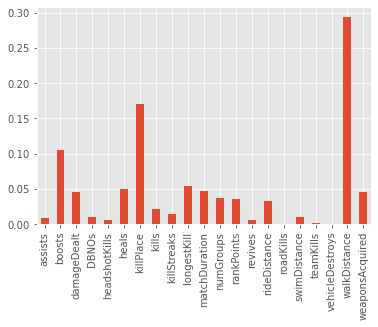

In [42]:
# code adapted from: https://machinelearningmastery.com/calculate-feature-importance-with-python/

# get importance
importance = pipeline_randomforest.steps[1][1].feature_importances_
forest_importance = pd.Series(importance, cols_df[0:23])

# summarize feature importance
for name, v in forest_importance.items():
    print('Feature: {} Score: {:.5f}'.format(name.ljust(16), v))

# plot feature importance
forest_importance.plot.bar()
plt.show()

We can see from the graph above that walkDistance is the feature with the most importance in our model, followed by killPlace, boosts, and damageDealt. Here are a few comments about each of these.

1. walkDistance: This variable represents the total distance walked by a player during the match. It makes sense that the walk distance would be an imporant factor for influencing the target variable (quart_binary); a player that places higher would be alive longer, and travel a greater distance, as compared to players that place lower (aka die early).

2. killPlace: This variable represents a ranking in a given match, based on the number of enemy players killed. More enemy players killed means a better placement. It makes sense that this would be influential for our target variable, destroying a greater number of the other players means that there are fewer players to place higher than you. Additional research into analysis performed by others suggests that very few players adopt a 'passive' strategy (one in which they do not go on the offensive, attacking other players), and that even fewer manage to place highly in a given match when they have a minimal enemy kill count.

3. boosts: Boosts are items that give players extra "boosts" of life; so if a player's health is diminished, they can use boost items to replenish their health, which in turn allows them to continue to play longer, which increases the chances that they will place higher.

4. damageDealt: This variable represents the amount of damage that the player inflicts (ex: wounding or killing other players). The same thought process as killPlace applies to this variable; the more damage a player causes on enemy players, the greater the opportunity for that player to last longer in the game, and place higher. 

#### Comparison: Logistic Regression v. Random Forest

For two of our models (SGDClassifier with hinge-loss was not included), the weights included *killPlace* and *walkDistance* when predicting for the response, *quart_binary*. There was some disagreement between the LogisticRegression and RandomForest models with respect to the third most important variable. However, both models are producing accuracies greater than 90%; therefore, much of the prediction power could be attributed to these two features.

## **INTERPRETING SUPPORT VECTORS**

*Below code adapted from: https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html*

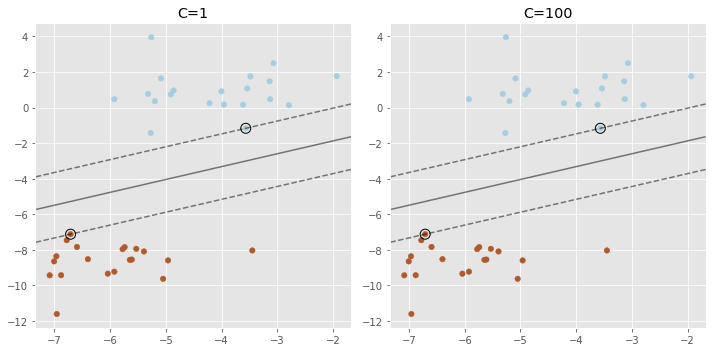

In [43]:
# graph the support vectors

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC

X, y = make_blobs(n_samples=40, centers=2, random_state=17)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=17).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
    )
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(
        xx,
        yy,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

The above code gives a representation of the support vectors for our classification QOI. The support vectors  are the instances that lie *on* the hyperplane boundary separating our classifications. These represent maximized margins between our binary classes; but because we are running our model against multi-variate data, the support vectors exist on hyperplanes separating our data as optimally as possible.

As we increase the regularization parameter (*i.e.* C), we decrease the strength of regularization: "The strength of the regularization is inversely proportional to C." ([reference](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)). In other words, a larger C overfits on our training data—as seen above.

In [44]:
# code adapted from: https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

from sklearn.svm import SVC
clf = SVC(C = 1e2, kernel = 'linear')
clf.fit(X, y) 
print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))

w =  [[-0.08343166 -0.33020906]]
b =  [-1.91016132]
Indices of support vectors =  [22 30]
Support vectors =  [[-5.27207303 -1.42425968]
 [-6.71056416 -7.11757559]]
Number of support vectors for each class =  [1 1]
Coefficients of the support vector in the decision function =  [[0.05799943 0.05799943]]


We increased our value for C, which increases the penalty for mis-classifications in our model predictions. 

In [ ]:
# https://datascience.stackexchange.com/questions/4943/intuition-for-the-regularization-parameter-in-svm